In [53]:
## Packages necessary for exploratory analysis
install.packages("conflicted")
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(dplyr)
library(conflicted)
library(lubridate)


conflict_prefer("select", "dplyr")
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::select over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::filter over any other package

[conflicted] Removing existing preference

[conflicted] Will prefer dplyr::lag over any other package



# Project Proposal: Case study analysis: Holidays in COVID-19¶
**Authors: Fares Burwag (14729412), Nikko Dumrique (63631204)**

## Introduction

Public holidays are associated with indoor social gatherings; particularly interactions with people one would usually not interact with (extended family, friends, mass gatherings, etc...) in addition to an increase in domestic and international travel [1]. These are high risk activities generally associated with COVID19 disease transmission [2,3].  Despite this, we noticed a research gap when it came to studies addressing the impacts of public holidays on disease case numbers and transmission; paritcularly with COVID19. One german study  found a significant increase in case numbers associated with summer holiday seasons in the country [4]. In this study, we aim to use publicly provided data [5] to investigate whether public holidays in large Canadian provinces substantially increase the proportion of positive COVID tests.

## Preliminary Study

We begin our exploratory analysis by visualizing nationwide data. After selecting our columns of interest (province ID, province name, dates, number of confirmed cases, and total tests administered), we created two new columns: conftoday and testedtoday. These measure the number of new confirmed cases and the number of tests available per day. We also used conditional statements to account for days where data was not available.

Additional columns, windowavg and windowtestavg, were created to reduce noise in visualization. These measured 6-day averages for number of confirmed cases and the number of available tests, respectively. We calculated an additional statistics called windowpropavg, which measured the 6-day average proportion of positive patients out of the total number of tests available.

In [2]:
##Loading data remotely
covid <- read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  prname = col_character(),
  prnameFR = col_character(),
  date = col_date(format = ""),
  update = col_logical(),
  percentrecover = col_character()
)

See spec(...) for full column specifications.



In [3]:
##Brief tidying:

covid_tidy <- covid %>% select(pruid, prname, date, numconf, numtests) %>%
    filter(prname %in% c("Canada", "Ontario", "Quebec", "British Columbia", "Alberta"))%>%
    arrange(prname)%>%
    mutate(conftoday = ifelse(prname == lag(prname,1), ifelse((date - 1) == lag(date, k = 1), numconf - lag(numconf), 
                               ifelse((date - 1) == lag(date, k = 2), (numconf - lag(numconf))/2, 
                                      ifelse((date - 1) == lag(date, k = 3), (numconf - lag(numconf))/3, 
                                            ifelse((date - 1) == lag(date, k = 4), (numconf - lag(numconf))/4, 
                                                  ifelse((date - 1) == lag(date, k = 5), (numconf - lag(numconf))/5, 
                                                       ifelse((date - 1) == lag(date, k = 6), (numconf - lag(numconf))/6, 
                                                              ifelse((date - 1) == lag(date, k = 7), (numconf - lag(numconf))/7,
                                                                    ifelse((date - 1) == lag(date, k = 8), (numconf - lag(numconf))/8, 
                                                                          ifelse((date - 1) == lag(date, k = 9), (numconf - lag(numconf))/9,
                                                                                 ifelse((date - 1) == lag(date, k = 10), (numconf - lag(numconf))/10, NA)))))))))), NA), 
          testedtoday = ifelse(prname == lag(prname,1), ifelse((date - 1) == lag(date, k = 1), numtests - lag(numtests), 
                               ifelse((date - 1) == lag(date, k = 2), (numtests - lag(numtests))/2, 
                                      ifelse((date - 1) == lag(date, k = 3), (numtests - lag(numtests))/3,
                                            ifelse((date - 1) == lag(date, k = 4), (numtests - lag(numtests))/4, 
                                                  ifelse((date - 1) == lag(date, k = 5), (numtests - lag(numtests))/5, 
                                                       ifelse((date - 1) == lag(date, k = 6), (numtests - lag(numtests))/6, 
                                                              ifelse((date - 1) == lag(date, k = 7), (numtests - lag(numtests))/7,
                                                                    ifelse((date - 1) == lag(date, k = 8), (numtests - lag(numtests))/8, 
                                                                          ifelse((date - 1) == lag(date, k = 9), (numtests - lag(numtests))/9,
                                                                                 ifelse((date - 1) == lag(date, k = 10), (numtests - lag(numtests))/10, NA)))))))))), NA)
          )%>% 
    filter(!is.na(conftoday), conftoday > 0) %>%
    mutate(windowavg = (conftoday + lag(conftoday, 1) + lag(conftoday, 2) + lag(conftoday, 3))/4,
          windowtestavg = (testedtoday + lag(testedtoday, 1) + lag(testedtoday, 2) + lag(testedtoday, 3) + lag(testedtoday, 4) + lag(testedtoday, 5))/6,
          windowpropavg = windowavg/windowtestavg)

## At this point, we filter for Canada-wide data.

covid_tidy_Canada <- 
    filter(covid_tidy, prname == 'Canada')






Once we have tidied our data and specified Canada-wide values, we visualized it using a line graph. We marked federal holidays [6] by vertical green lines and shaded the following 17-day window when we expect to see a hike in daily proportion of positive COVID19 cases.

Parsed with column specification:
cols(
  date = col_date(format = ""),
  holiday = col_character()
)

Parsed with column specification:
cols(
  date = col_date(format = ""),
  holiday = col_character()
)

Warning message:
“Ignoring unknown aesthetics: x”


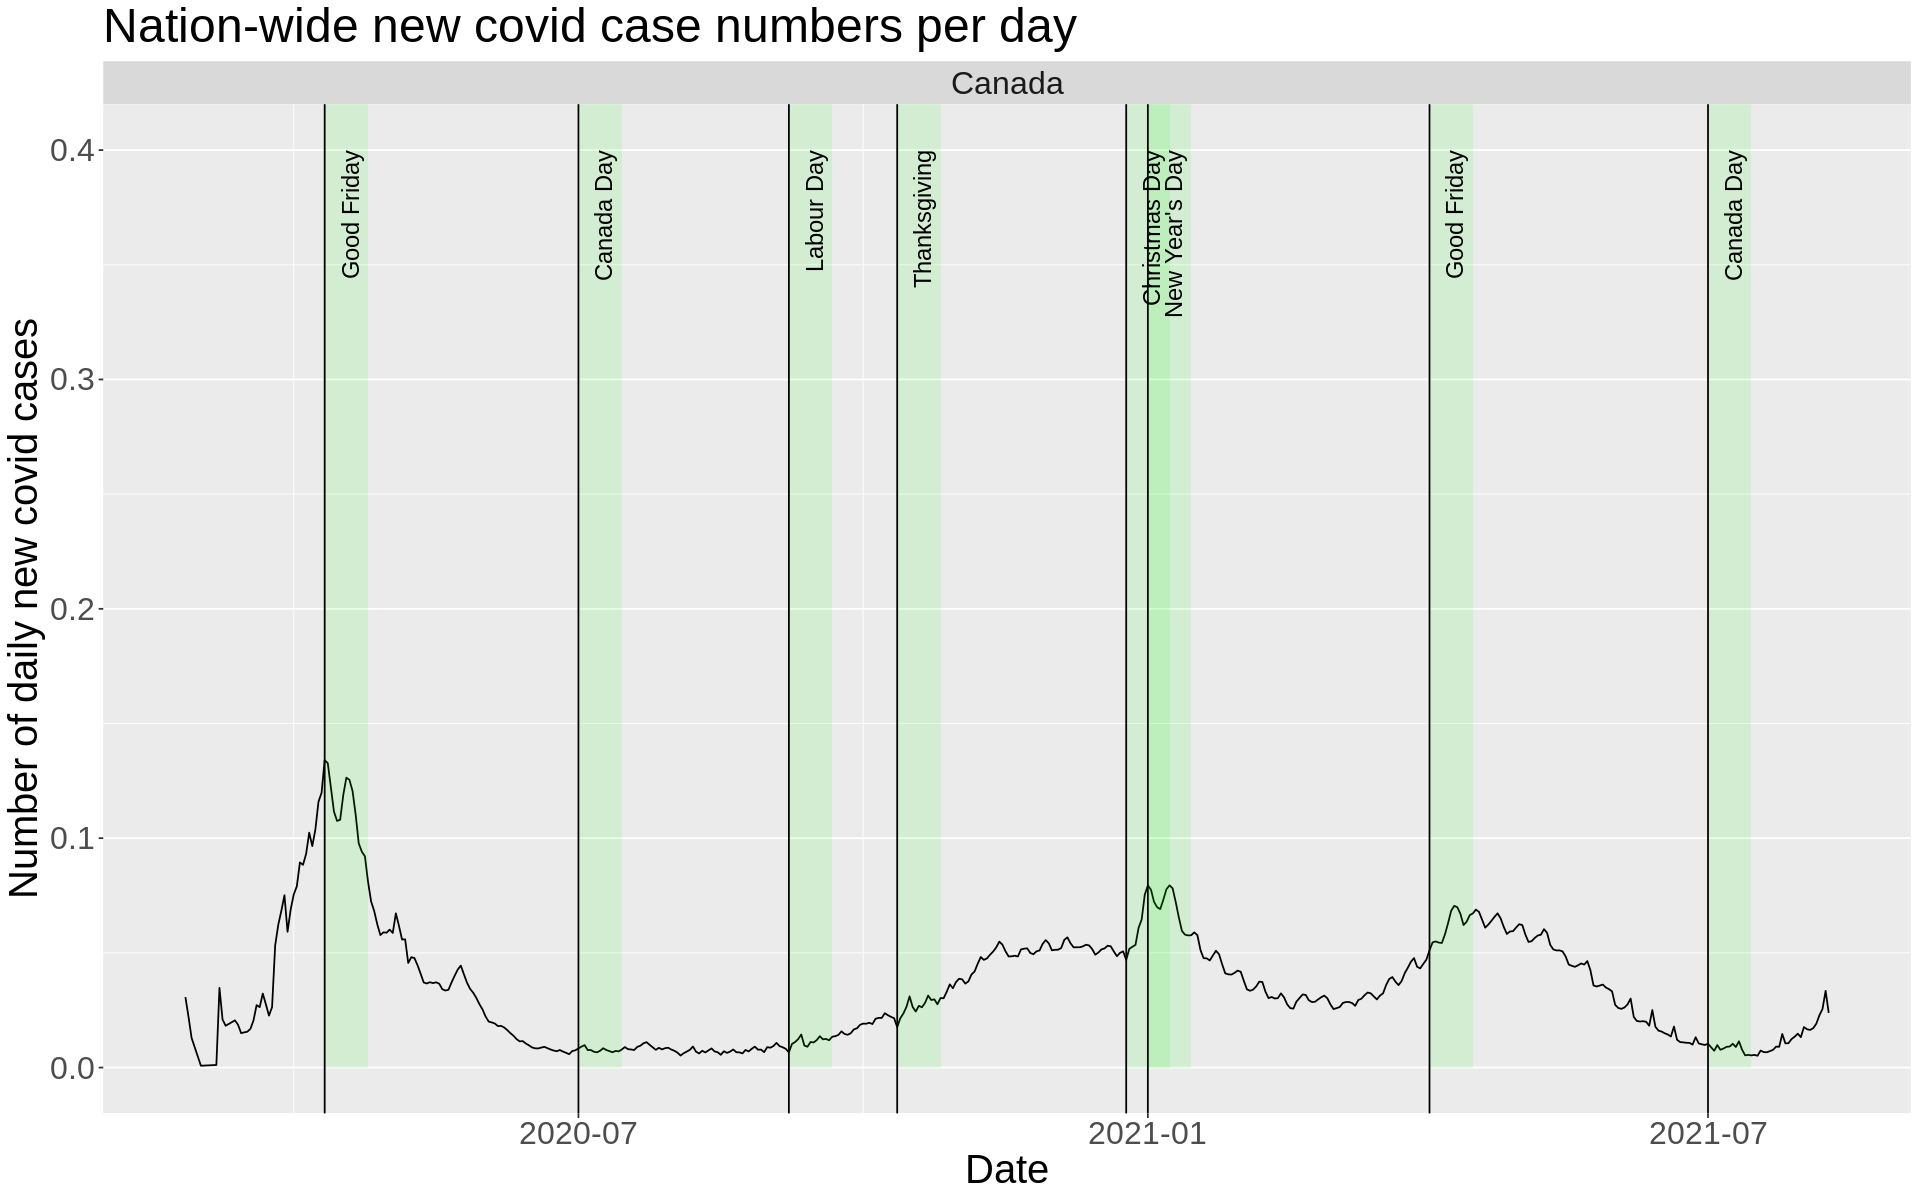

In [4]:


public_holidays  <- read_csv("https://raw.githubusercontent.com/uWaterloo/Datasets/master/Holidays/holidays.csv")%>% 
    filter(holiday %in% c("New Year's Day", "Good Friday", "Canada Day", 
                          "Labour Day", "Thanksgiving", "Christmas Day"))  %>% 
    filter(date >= min(covid_tidy$date), date <= max(covid_tidy$date))

public_holiday_bound <- public_holidays  %>% 
    mutate(post_holiday = date + 17, pre_holiday = date - 7) 


public_holidays_table <-  read_csv("https://raw.githubusercontent.com/uWaterloo/Datasets/master/Holidays/holidays.csv")%>% 
    filter(holiday %in% c("New Year's Day", "Good Friday", "Canada Day", 
                          "Labour Day", "Thanksgiving", "Christmas Day"))  %>% 
    filter(date >= min(covid_tidy$date), date <= max(covid_tidy$date))


options(repr.plot.width=16, repr.plot.height=10)

conf_today_graph <- covid_tidy_Canada %>%
    ggplot()+
#     geom_line(aes(x = date, y = windowpropavg))+
    geom_line(aes(x = date, y = windowpropavg))+
#     geom_line(aes(x = date, y = windowtestavg, color = 'red'))+
    facet_wrap(.~prname)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[1],
             xmax = (public_holidays$date[1] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[2],
             xmax = (public_holidays$date[2] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[3],
             xmax = (public_holidays$date[3] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[4],
             xmax = (public_holidays$date[4] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[5],
             xmax = (public_holidays$date[5] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[6],
             xmax = (public_holidays$date[6] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[7],
             xmax = (public_holidays$date[7] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[8],
             xmax = (public_holidays$date[8] + 14), fill = 'green', alpha = .1)+
    annotate(geom = "vline",
             x = c(public_holidays$date),
             xintercept = public_holidays$date) +
    annotate(geom = "text",
             label = as.character(public_holidays$holiday),
             x = c(public_holidays$date),
             y = c(0.4),
             angle = 90, 
             vjust = 2, hjust = 1, size = 5)+
    ggtitle("Nation-wide new covid case numbers per day")+
    labs(x = "Date", y = "Number of daily new covid cases")+
    theme(text = element_text(size = 24))



conf_today_graph

The above graph (Canada-wide), indicates slight hikes in new case counts following federal holidays - particularly Christmas/New Years and Good Friday (2021). We investigated these patterns on the provincial level - particularly larger provinces with populations greater than 4 million to ensure comparability. Therefore we will explore only Ontario, Quebec, British Columbia, and Alberta. In addition to case counts, we also visualized the proportion of positive tests (number of confirmed cases/number of tests) to determine which estimator provides more information.

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 5 row(s) containing missing values (geom_path).”


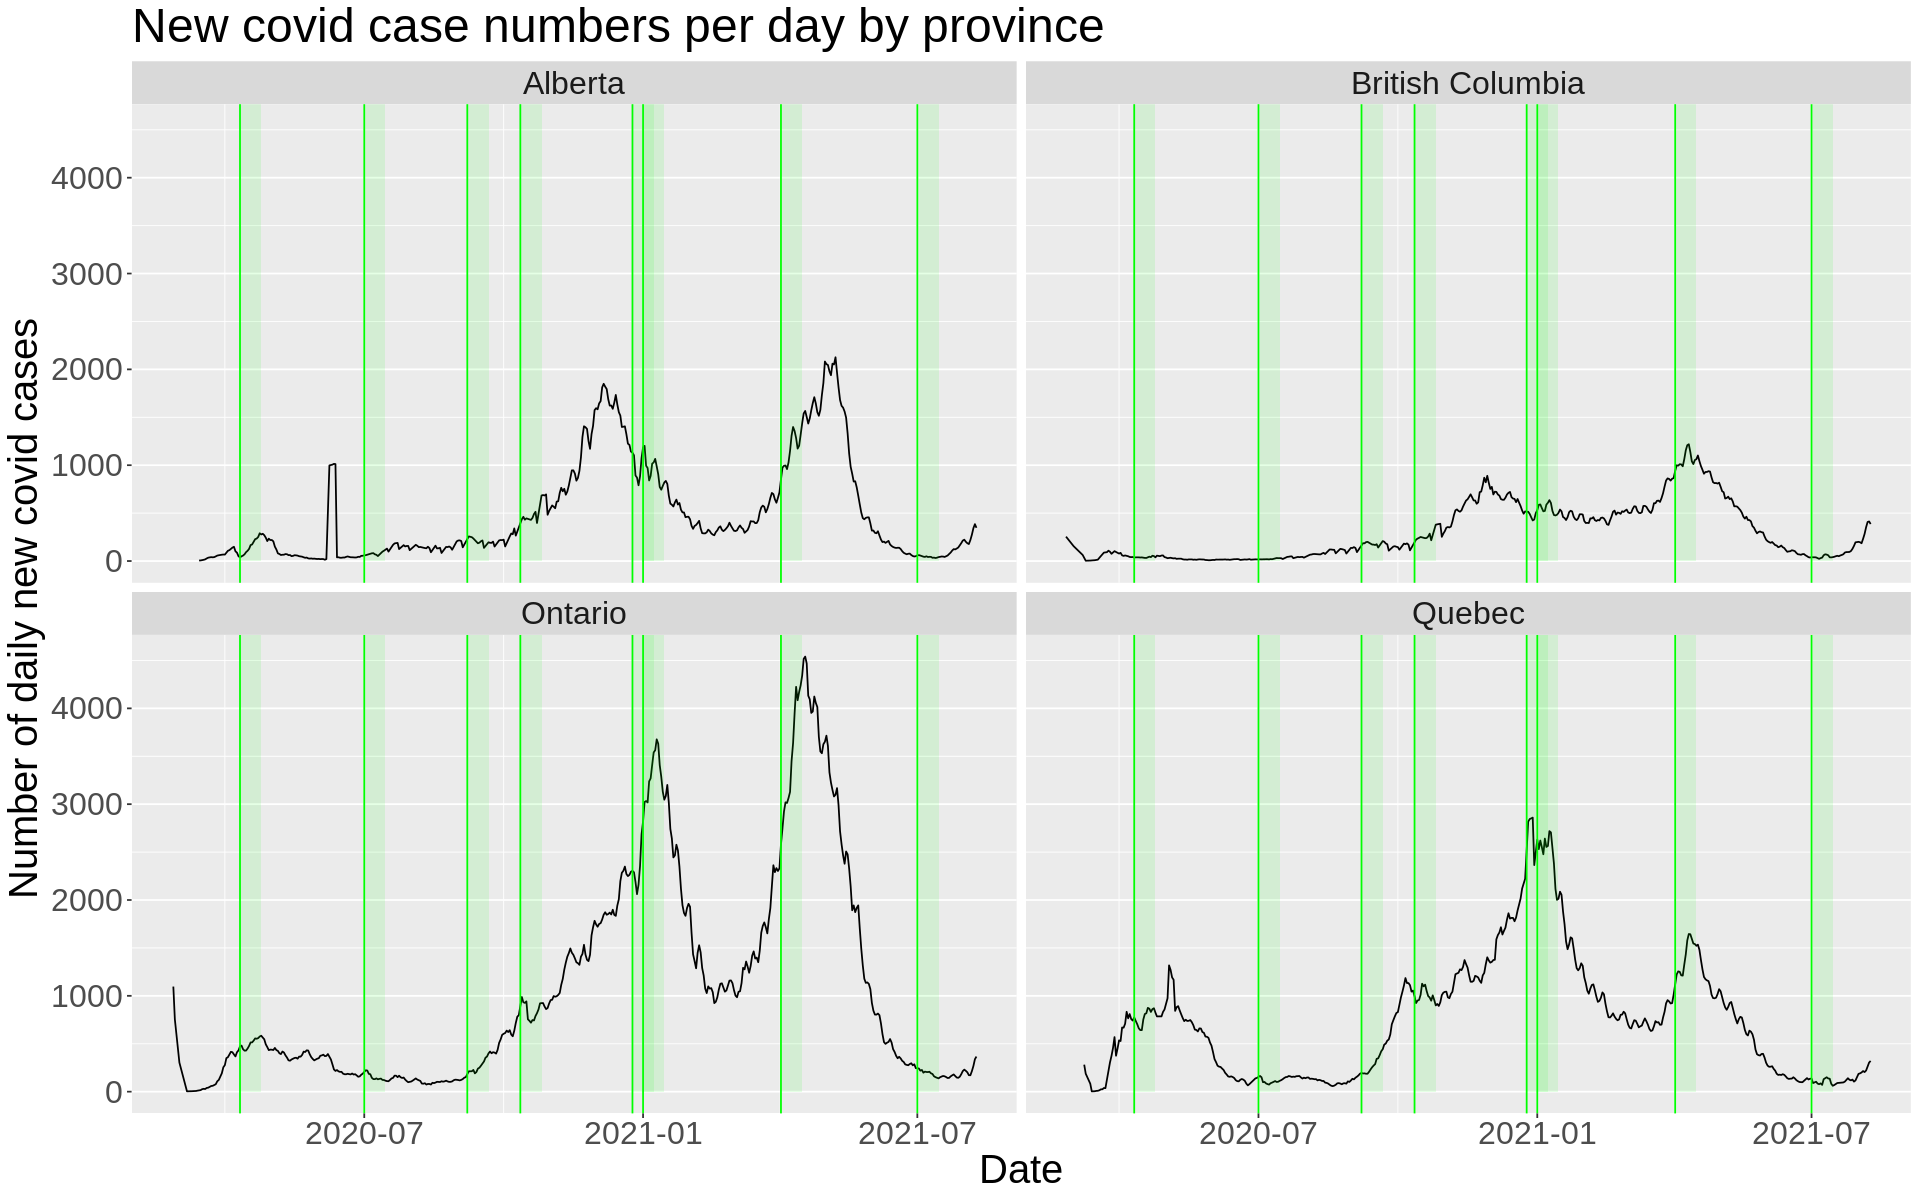

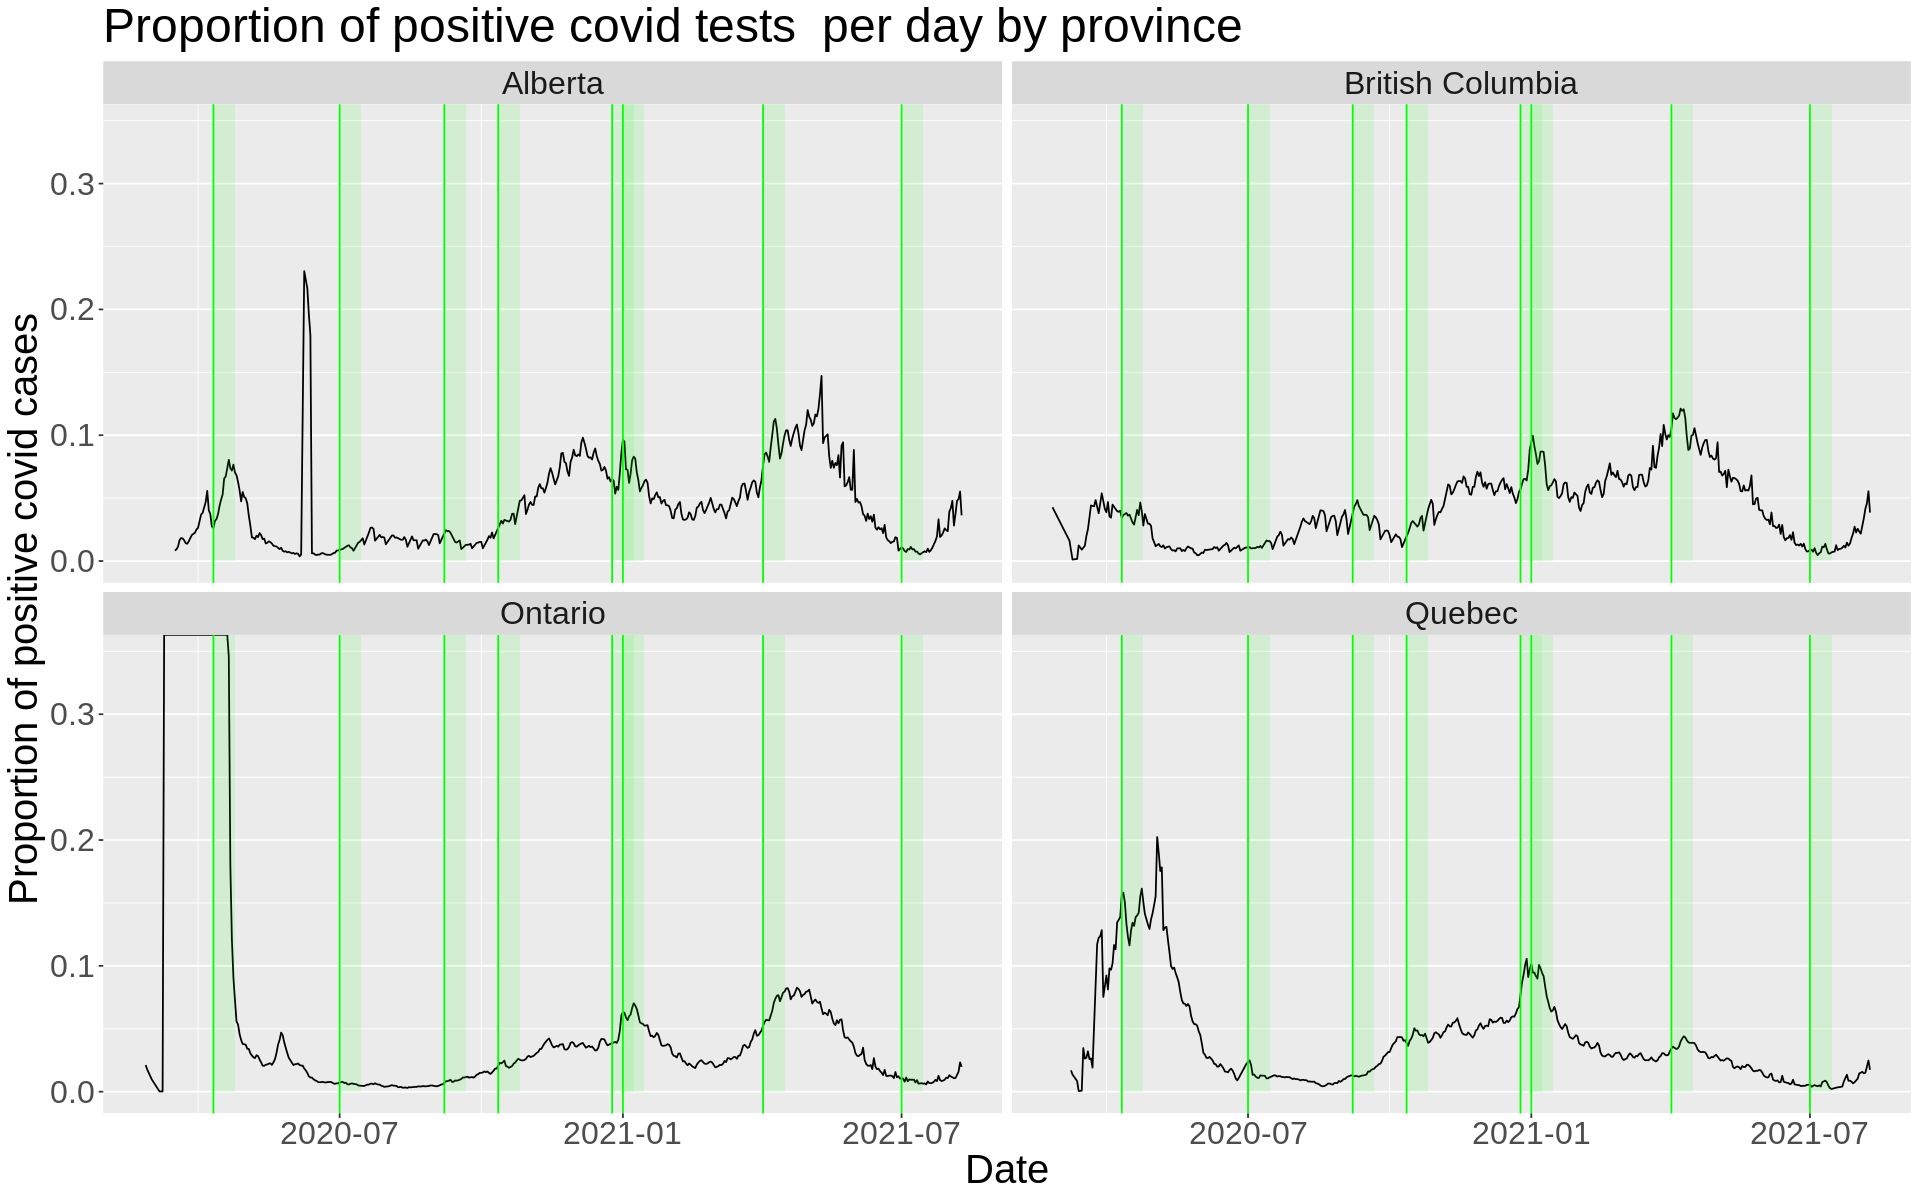

In [5]:
covid_tidy_provinces <- covid_tidy %>%
    filter(prname %in% c("Ontario", "Quebec", "British Columbia", "Alberta")) 
public_holidays_vis <- public_holidays_table %>% 
    bind_rows(public_holidays_table, public_holidays_table, public_holidays_table)

public_holiday_exp <- public_holidays %>%
    bind_rows(public_holidays)

conf_today_graph_provinces <- covid_tidy_provinces %>%
    ggplot()+
    geom_line(aes(x = date, y = windowavg))+
    facet_wrap(.~prname)+
    geom_vline(xintercept = public_holidays$date, color = 'green')+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[1],
             xmax = (public_holidays$date[1] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[2],
             xmax = (public_holidays$date[2] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[3],
             xmax = (public_holidays$date[3] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[4],
             xmax = (public_holidays$date[4] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[5],
             xmax = (public_holidays$date[5] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[6],
             xmax = (public_holidays$date[6] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[7],
             xmax = (public_holidays$date[7] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[8],
             xmax = (public_holidays$date[8] + 14), fill = 'green', alpha = .1)+
    ggtitle("New covid case numbers per day by province")+
    labs(x = "Date", y = "Number of daily new covid cases")+
    theme(text = element_text(size = 24))


prop_today_graph_provinces <- covid_tidy_provinces %>%
    ggplot()+
    geom_line(aes(x = date, y = windowpropavg))+
    facet_wrap(.~prname)+
    geom_vline(xintercept = public_holidays$date, color = "green")+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[1],
             xmax = (public_holidays$date[1] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[2],
             xmax = (public_holidays$date[2] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[3],
             xmax = (public_holidays$date[3] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[4],
             xmax = (public_holidays$date[4] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[5],
             xmax = (public_holidays$date[5] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[6],
             xmax = (public_holidays$date[6] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[7],
             xmax = (public_holidays$date[7] + 14), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holidays$date[8],
             xmax = (public_holidays$date[8] + 14), fill = 'green', alpha = .1)+
    ggtitle("Proportion of positive covid tests  per day by province")+
    labs(x = "Date", y = "Proportion of positive covid cases")+
    theme(text = element_text(size = 24))

conf_today_graph_provinces
prop_today_graph_provinces

We determined from above that while case counts provide a clearer visualization of transmission throughout the pandemic, using proportions is a  more comparable estimator as it standardizes our values across provinces and across time. This allows us to compare numbers from the beginning of the pandemic to those later on.

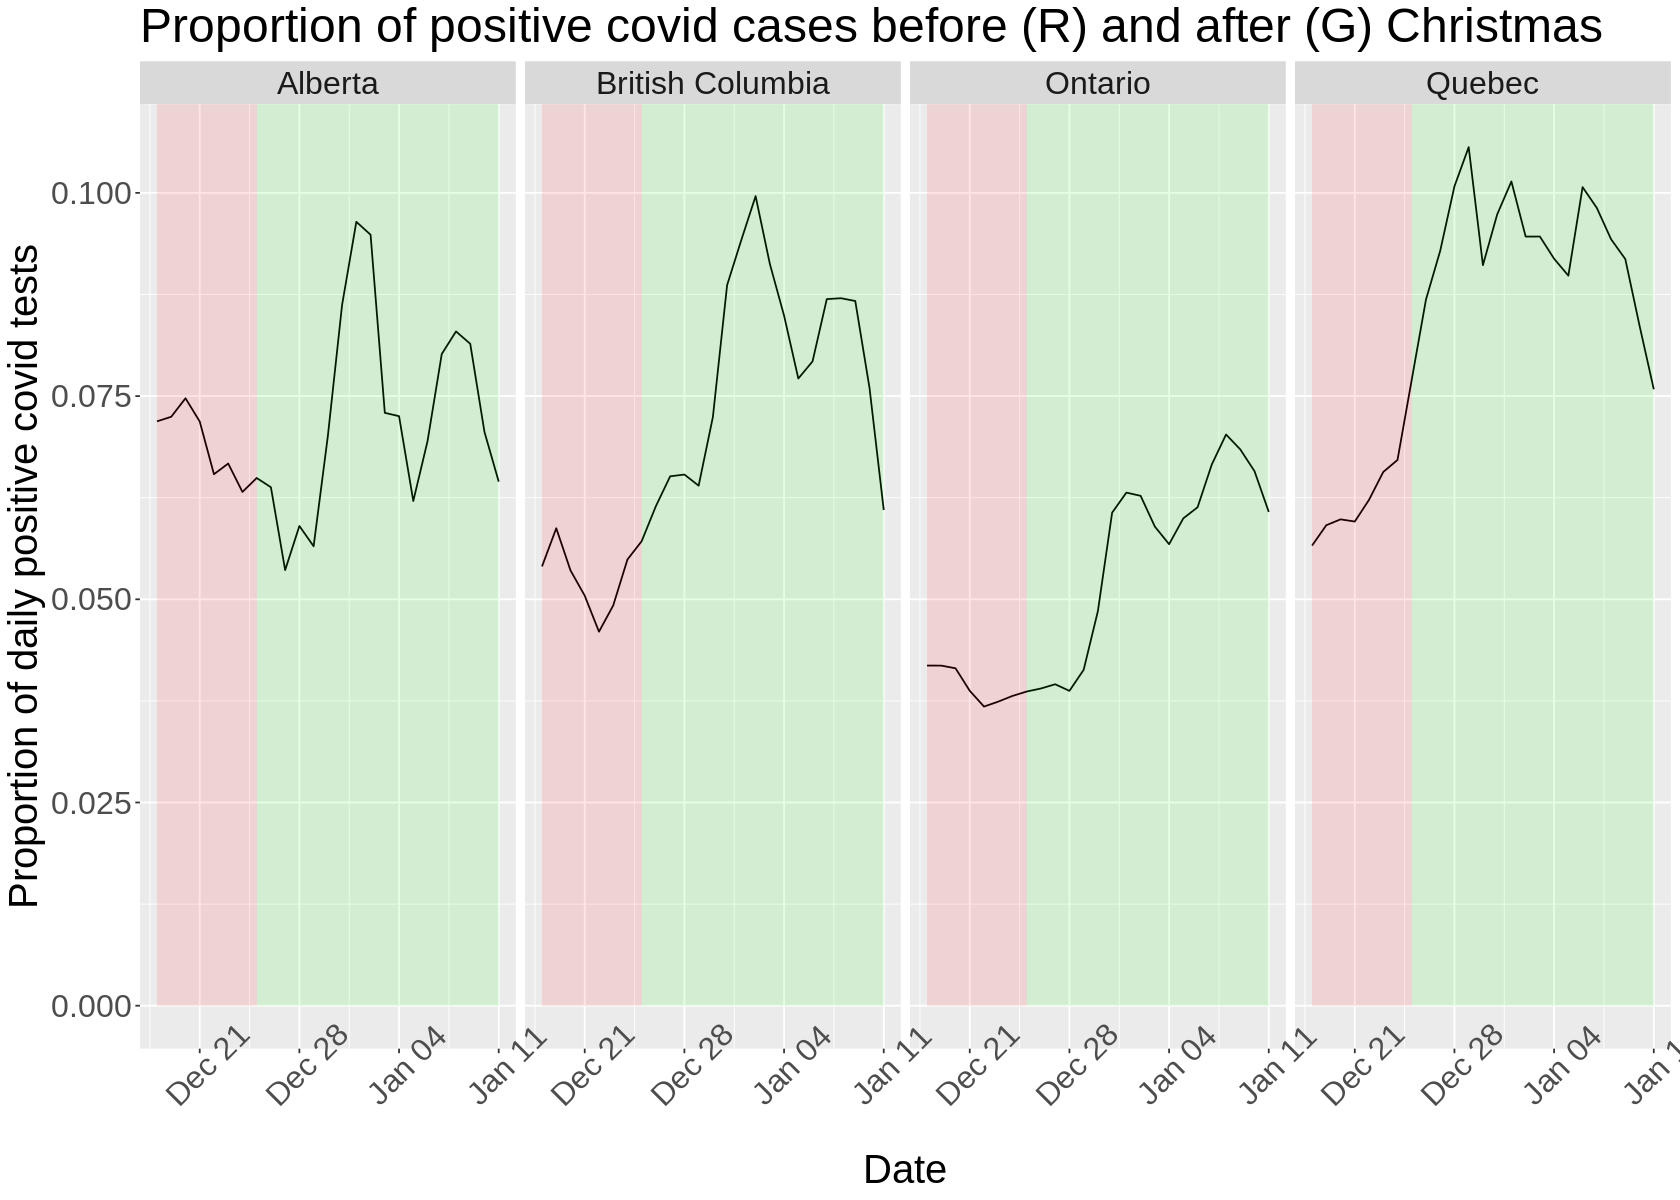

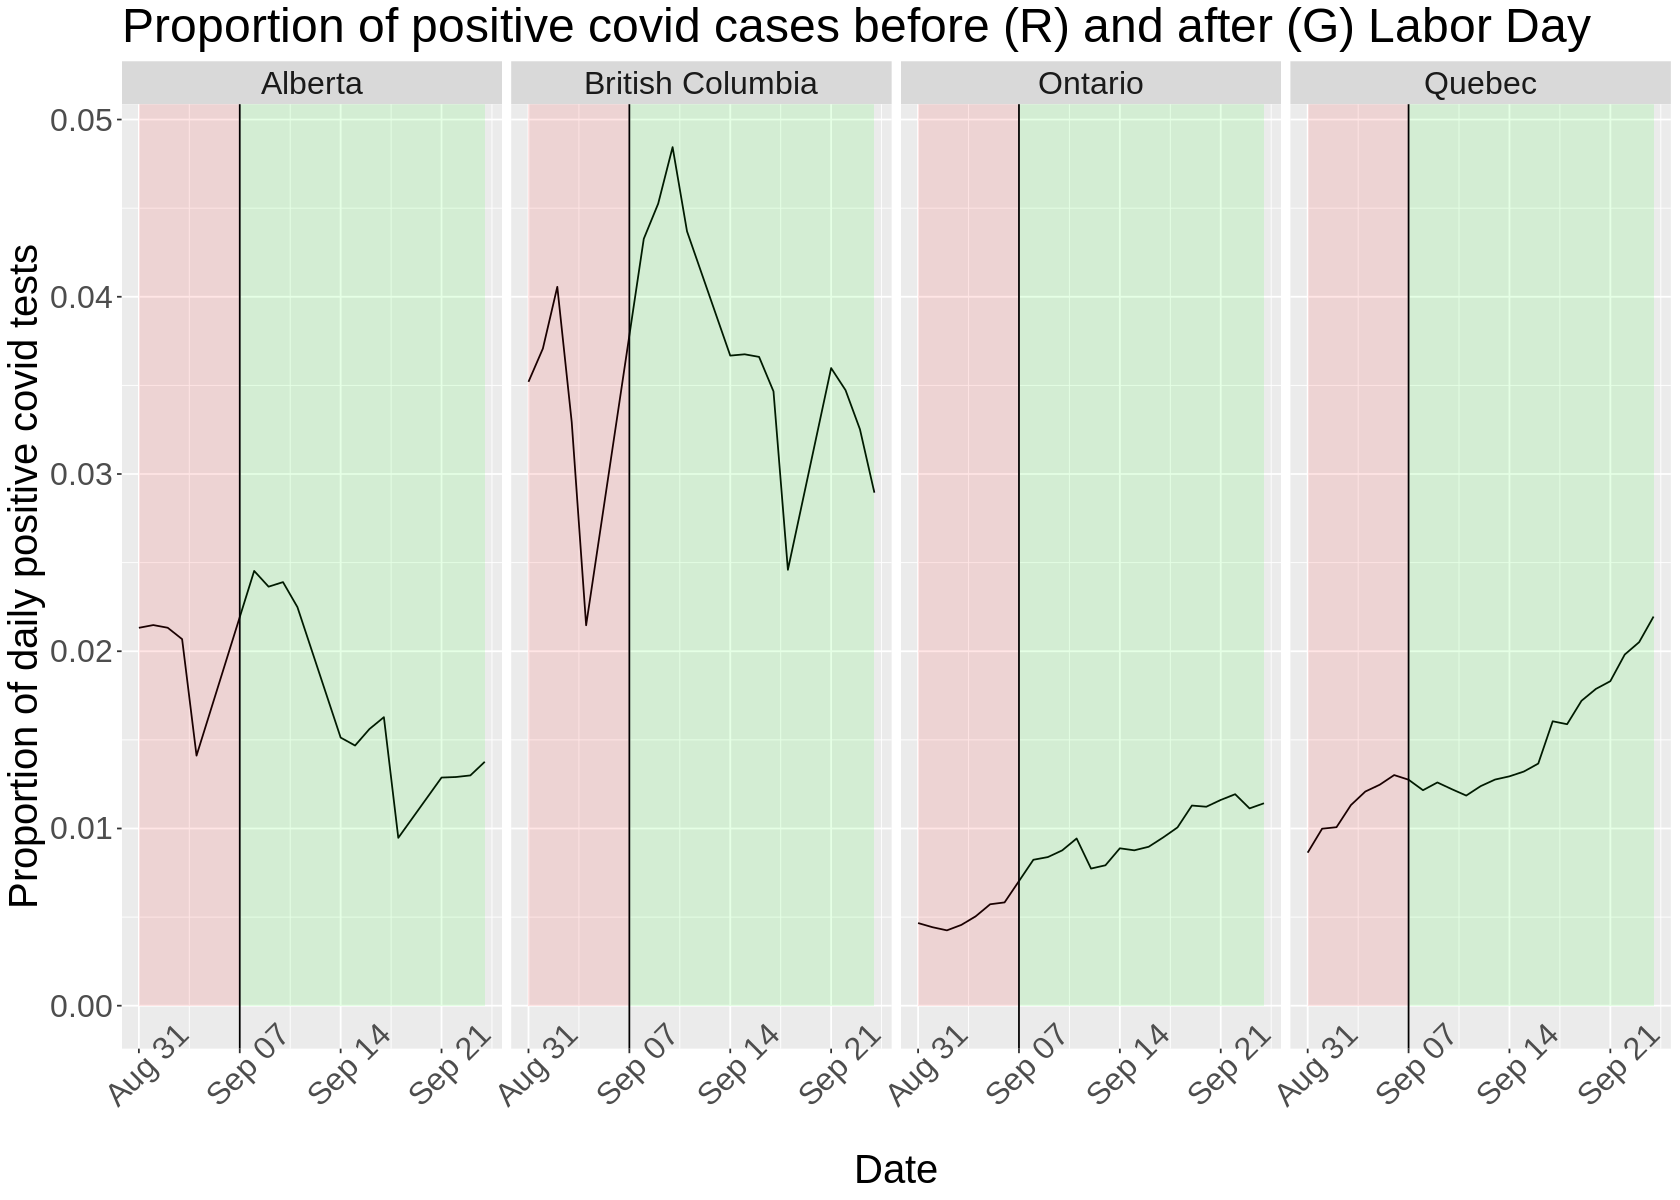

In [6]:

options(repr.plot.width=14, repr.plot.height=10)

covid_christmas <- covid_tidy_provinces %>%
    filter(date >= public_holiday_bound$pre_holiday[5] & date <= public_holiday_bound$post_holiday[5])

covid_christmas_graph <- ggplot(covid_christmas)+
    geom_line(aes(x = date, y = windowpropavg))+
    facet_wrap(.~prname, nrow = 1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holiday_bound$date[5],
             xmax = (public_holiday_bound$post_holiday[5]), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holiday_bound$pre_holiday[5],
             xmax = (public_holiday_bound$date[5]), fill = 'red', alpha = .1)+
    ggtitle("Proportion of positive covid cases before (R) and after (G) Christmas")+
    labs(x = "Date", y = "Proportion of daily positive covid tests")+
    theme(text = element_text(size = 24))+ 
    theme(axis.text.x = element_text(angle = 45))


covid_laborday <- covid_tidy_provinces %>%
    filter(date >= public_holiday_bound$pre_holiday[3] & date <= public_holiday_bound$post_holiday[3])

covid_laborday_graph <- ggplot(covid_laborday)+
    geom_line(aes(x = date, y = windowpropavg))+
    facet_wrap(.~prname, nrow = 1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holiday_bound$date[3],
             xmax = (public_holiday_bound$post_holiday[3]), fill = 'green', alpha = .1)+
    annotate(geom = 'rect', ymin = 0, ymax = Inf, xmin = public_holiday_bound$pre_holiday[3],
             xmax = (public_holiday_bound$date[3]), fill = 'red', alpha = .1)+
    geom_vline(xintercept = public_holidays$date[3])+
    ggtitle("Proportion of positive covid cases before (R) and after (G) Labor Day")+
    labs(x = "Date", y = "Proportion of daily positive covid tests")+
    theme(text = element_text(size = 24)) + 
    theme(axis.text.x = element_text(angle = 45))




covid_christmas_graph
covid_laborday_graph

The previous graph indicates an apparent increase in case numbers following Christmas within Ontario and Quebec. Alberta and B.C., on the other hand, seem to maintain either level or fluctuating numbers. Based on these visualizations, we determine there could potentially indeed be a difference in proportions of positive tests. In the following table, we summarized the population data we are interested:

In [50]:

pre_good_friday = ymd(public_holiday_bound$pre_holiday[public_holiday_bound$holiday == 'Good Friday'])
pre_canada_day = ymd(public_holiday_bound$pre_holiday[public_holiday_bound$holiday == 'Canada Day'])
pre_labour_day = ymd(public_holiday_bound$pre_holiday[public_holiday_bound$holiday == 'Labour Day'])
pre_thanksgiving = ymd(public_holiday_bound$pre_holiday[public_holiday_bound$holiday == 'Thanksgiving'])
pre_christmas = ymd(public_holiday_bound$pre_holiday[public_holiday_bound$holiday == 'Christmas Day'])
pre_new_years = ymd(public_holiday_bound$pre_holiday[public_holiday_bound$holiday == "New Year's Day"])

post_good_friday = ymd(public_holiday_bound$post_holiday[public_holiday_bound$holiday == 'Good Friday'])
post_canada_day = ymd(public_holiday_bound$post_holiday[public_holiday_bound$holiday == 'Canada Day'])
post_labour_day = ymd(public_holiday_bound$post_holiday[public_holiday_bound$holiday == 'Labour Day'])
post_thanksgiving = ymd(public_holiday_bound$post_holiday[public_holiday_bound$holiday == 'Thanksgiving'])
post_christmas = ymd(public_holiday_bound$post_holiday[public_holiday_bound$holiday == 'Christmas Day'])
post_new_years = ymd(public_holiday_bound$post_holiday[public_holiday_bound$holiday == "New Year's Day"])

good_friday = ymd(public_holiday_bound$date[public_holiday_bound$holiday == 'Good Friday'])
canada_day = ymd(public_holiday_bound$date[public_holiday_bound$holiday == 'Canada Day'])
labour_day = ymd(public_holiday_bound$date[public_holiday_bound$holiday == 'Labour Day'])
thanksgiving = ymd(public_holiday_bound$date[public_holiday_bound$holiday == 'Thanksgiving'])
christmas = ymd(public_holiday_bound$date[public_holiday_bound$holiday == 'Christmas Day'])
new_years = ymd(public_holiday_bound$date[public_holiday_bound$holiday == "New Year's Day"])

covid_clean  <- covid_tidy_provinces  %>%  filter(testedtoday != 0)%>%
    mutate(holiday = case_when(
        between(date, pre_good_friday, post_good_friday) ~ "Good Friday",
        between(date, pre_canada_day, post_canada_day)  ~ "Canada Day",
        between(date, pre_labour_day, post_labour_day)  ~ "Labor Day",
        between(date, pre_thanksgiving, post_thanksgiving)  ~ "Thanksgiving", 
        between(date, pre_christmas, post_christmas)  ~ "Christmas Day",
        between(date, pre_new_years, post_new_years)  ~ "New Year's Day"))  %>%
    filter(!is.na(holiday))%>%
    mutate(category = case_when(
        between(date, pre_good_friday, good_friday-1)  | 
        between(date, pre_canada_day, canada_day-1) |
        between(date, pre_labour_day, post_labour_day-1)  |
        between(date, pre_thanksgiving, thanksgiving-1)  |
        between(date, pre_christmas, christmas-1)  |
        between(date, pre_new_years, new_years-1)  ~ "preholiday",
        between(date,canada_day+1,  post_canada_day)  | 
        between(date, christmas+1, post_christmas) |
        between(date, good_friday+1, post_good_friday) |
        between(date, labour_day+1, post_labour_day) |
        between(date, new_years+1, post_new_years) |
        between(date, thanksgiving+1, post_thanksgiving) ~ "postholiday",
        date == good_friday  | 
        date == canada_day |
        date == labour_day |
        date == thanksgiving |
        date == christmas |
        date == new_years ~ "duringholiday"))

covid_summary <- covid_clean %>%
    group_by(prname, category)%>%
    summarize(mean_prop = mean(windowpropavg), sample_size = n())%>%
    filter(category != "duringholiday")%>%
    pivot_wider(names_from = category, values_from = mean_prop:sample_size)%>%
    mutate(prop_diff = mean_prop_postholiday - mean_prop_preholiday)

covid_summary

`summarise()` regrouping output by 'prname' (override with `.groups` argument)



prname,mean_prop_postholiday,mean_prop_preholiday,sample_size_postholiday,sample_size_preholiday,prop_diff
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
Alberta,0.04359464,0.03220092,44,43,0.011393721
British Columbia,0.04455813,0.03909478,44,41,0.005463348
Ontario,0.02952726,0.01830468,53,51,0.011222580
Quebec,0.04646310,0.03523517,53,48,0.011227938


In [52]:
#new analysis
head(covid_clean)
covid_clean  %>% mutate(lol = between(date, pre_good_friday, post_good_friday))  %>% 
    select(lol)

pruid,prname,date,numconf,numtests,conftoday,testedtoday,windowavg,windowtestavg,windowpropavg,holiday,category
<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
48,Alberta,2020-06-24,7825,401898,44,6542,38.00,7680.333,0.004947702,Canada Day,preholiday
48,Alberta,2020-06-25,7851,408416,26,6518,36.75,7463.167,0.004924183,Canada Day,preholiday
48,Alberta,2020-06-26,7888,414783,37,6367,38.00,7007.667,0.005422632,Canada Day,preholiday
48,Alberta,2020-06-27,7957,421417,69,6634,44.00,6880.000,0.006395349,Canada Day,preholiday
48,Alberta,2020-06-28,7996,427813,39,6396,42.75,6558.667,0.006518093,Canada Day,preholiday
48,Alberta,2020-06-29,8067,434323,71,6510,54.00,6494.500,0.008314728,Canada Day,preholiday


lol
<lgl>
FALSE
FALSE
FALSE
FALSE
FALSE
FALSE
FALSE
FALSE
FALSE


In [16]:
head(covid_summary)
tail(covid_summary)

prname,mean_prop_postholiday,mean_prop_preholiday,sample_size_postholiday,sample_size_preholiday,prop_diff
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
Alberta,0.04765347,0.03328038,60,49,0.014373086
British Columbia,0.04256397,0.03919468,57,47,0.003369291
Ontario,0.04147894,0.01830468,61,51,0.023174259
Quebec,0.06910786,0.04599263,70,55,0.023115227


prname,mean_prop_postholiday,mean_prop_preholiday,sample_size_postholiday,sample_size_preholiday,prop_diff
<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
Alberta,0.04765347,0.03328038,60,49,0.014373086
British Columbia,0.04256397,0.03919468,57,47,0.003369291
Ontario,0.04147894,0.01830468,61,51,0.023174259
Quebec,0.06910786,0.04599263,70,55,0.023115227


In [32]:
alberta_null_dist = covid_clean  %>% 
    filter(category %in% c("preholiday","postholiday"))  %>% 
    specify(response = category ~ , success = "preholiday")  %>% 
    hypothesize(null = "independence")  %>% 
    generate(type = "permute", reps = 1000)  %>% 
    calculate(stat = "diff in props")
alberta_null_dist

ERROR: Error in parse(text = x, srcfile = src): <text>:3:35: unexpected ','
2:     filter(category %in% c("preholiday","postholiday"))  %>% 
3:     specify(response = category ~ ,
                                     ^


In [42]:
head(covid_clean)


pruid,prname,date,numconf,numtests,conftoday,testedtoday,windowavg,windowtestavg,windowpropavg,holiday,category
<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
48,Alberta,2020-04-03,1075,56027,107,3610,113.50,2966.167,0.03826488,Good Friday,preholiday
48,Alberta,2020-04-05,1250,61759,175,1723,140.00,2979.167,0.04699301,Good Friday,preholiday
48,Alberta,2020-04-06,1348,63566,98,1807,148.50,2664.167,0.05573976,Good Friday,preholiday
48,Alberta,2020-04-07,1373,64751,25,1185,101.25,2504.167,0.04043261,Good Friday,preholiday
48,Alberta,2020-04-08,1423,65692,50,941,87.00,2339.500,0.03718743,Good Friday,preholiday
48,Alberta,2020-04-09,1451,67397,28,1705,50.25,1828.500,0.02748154,Good Friday,preholiday


pruid,prname,date,numconf,numtests,conftoday,testedtoday,windowavg,windowtestavg,windowpropavg,holiday,category
<dbl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
24,Quebec,2021-01-13,234695,4941745,2071,25282,2115.50,31857.33,0.06640543,New Year's Day,postholiday
24,Quebec,2021-01-14,236827,4976348,2132,34603,2001.50,31440.00,0.06366094,New Year's Day,postholiday
24,Quebec,2021-01-15,238745,5013255,1918,36907,2013.75,31129.17,0.06469014,New Year's Day,postholiday
24,Quebec,2021-01-16,240970,5049085,2225,35830,2086.50,30950.50,0.06741410,New Year's Day,postholiday
24,Quebec,2021-01-17,242914,5085399,1944,36314,2054.75,32305.00,0.06360471,New Year's Day,postholiday
24,Quebec,2021-01-18,244348,5114950,1434,29551,1880.25,33081.17,0.05683748,New Year's Day,postholiday


In [43]:
data = covid_clean  %>% 
    select(prname, category, windowavg, windowpropavg) 
head(data)
NROW(data)


prname,category,windowavg,windowpropavg
<chr>,<chr>,<dbl>,<dbl>
Alberta,preholiday,113.50,0.03826488
Alberta,preholiday,140.00,0.04699301
Alberta,preholiday,148.50,0.05573976
Alberta,preholiday,101.25,0.04043261
Alberta,preholiday,87.00,0.03718743
Alberta,preholiday,50.25,0.02748154


[1] 454

[1] 1945

Based on the summary table, we observe a slight difference in the proportion of positive covid tests between the pre-holiday and post-holiday numbers across all provinces. Since the difference is positive, this indicates that post-holiday has a mean higher proportion than pre-holiday.

## Method 

This report gives a strong foundation for the direction of further investigation. Visualizations of our data, alongside the calculated proportions, suggest an increase in proportions of daily confirmed cases post-holidays compared to pre-holiday populations (with an average of 𝚫p = 0.016). However, the visualizations and sample estimates above are strictly intended as an exploratory analysis. Further investigation, such as a hypothesis test, is needed to understand the relationships hidden behind the data. There is currently insufficient statistical evidence to support this claim. A couple of sources of uncertainty include the use number of tests available as opposed to the number of tests administered, the limited quantity of available data, and potential error in data collection.

We plan to deploy a bootstrap hypothesis test to assess our findings further. The dataset is substantially large enough for employing CLT, however, bootstrapping will enable us to further represent how our proportions can vary through simulation. Additionally, we will leverage the bootstrap samples to create a confidence interval to describe the difference in proportions between post and pre-holiday periods and assess whether the difference is statistically significant.

Discussion of our findings can further improve the response to future pandemics by informing policymakers and officials in planning public health strategies. Implementing case studies like COVID-19 responses within Canada can enhance the coordination and integration of public policies into everyday lives.

## References

1. Shi, P., Keskinocak, P., Swann, J. L., & Lee, B. Y. (2010). The impact of mass gatherings and holiday traveling on the course of an influenza pandemic: A computational model. BMC Public Health, 10(1). doi:10.1186/1471-2458-10-778
2. Daily Activities and Going Out. (n.d.). Retrieved from https://www.cdc.gov/coronavirus/2019-ncov/daily-life-coping/going-out.html
3. Canada, P. H. (2021, June 15). Government of Canada. Retrieved from https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection/prevention-risks/going-out-personal-social-activities-during-pandemic.html
4. Thomas Plümper, Eric Neumayer, Fueling the Covid-19 pandemic: summer school holidays and incidence rates in German districts, Journal of Public Health, 2021;, fdab080, https://doi.org/10.1093/pubmed/fdab080
5. Government of Canada. (2020, August 07). Public Health Infobase. Retrieved from https://health-infobase.canada.ca/
6. N.A, UWaterloo Open Datasets. Datasets at Master · UWaterloo/Datasets. Retrieved from https://github.com/uWaterloo/Datasets/tree/master/Holidays
